# Projet 4 : Anticipez les besoins en consommation de bâtiments

## NB 2 : Prédiction consommation en énergie 

### Sommaire
 
**Partie 1 : Importation du jeu de données**
 - <a href="#C1"> 1. Importation des données</a>
 
**Partie 2 : Régressions linéaires** 
 - <a href="#C2">2. Régressions linéaires  </a>
     - <a href="#C20"> 2.0 Baseline - Dummy Regressor </a>
     - <a href="#C21">2.1 Linear Regression OLS </a>
     - <a href="#C22">2.2 Ridge regression </a>
     - <a href="#C23">2.3 Lasso regression </a>
     - <a href="#C24">2.4 ElasticNet regression </a>
             
**Partie 3 : Régressions non linéaires** 
 - <a href="#C3"> 3. Régression non linéaires  </a>
     - <a href="#C31"> 3.1 SVR / LinearSVR </a>
     - <a href="#C32"> 3.2 DecisionTreeRegressor </a>
     - <a href="#C33"> 3.3 RandomForest </a>
     - <a href="#C34"> 3.4 XGBoost </a>

**Conclusion**
 - <a href="#C4"> 4. Conclusion </a>

# <a name="C1"> 1. Importation </a>

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import clean #mon module de fontions qui me permettent de nettoyer un dataframe
import plot_
import shap
import time


# Filter warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
file = ['df_set0.csv','df_set3.csv']

#Choix du fichier 0 ou 1
df= pd.read_csv(file[0],  
                dtype={'ID' : 'object',      
                      })
df = df.drop(columns = ['Unnamed: 0','INTENSITÉ_ÉMISSIONS','CONSOMMATION_ENERG_SITE', 'STEAM(kBtu)',
                        'SUPERFICIE_PARKING','Electricity(kBtu)', 'NaturalGas(kBtu)', 'ÉMISSIONS_TOTALES', 
                        'NAN_ENERGY', 
                        'FONCTION_2' ,  'FONCTION_3',
                        'LargestPropertyUseTypeGFA',
                        'SecondLargestPropertyUseTypeGFA',
                        'ThirdLargestPropertyUseTypeGFA'
                      ])


In [4]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import sklearn
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, RobustScaler,  StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn import set_config
from category_encoders import *
set_config(display="diagram")

In [6]:
df.head()

,ID,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,INT_CONSOMMATION_ENERG_SITE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part
0,1,NONRESIDENTIAL,HOTEL,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,84.300003,60.0,0.000000,0.277302,0.546060,0.176638
1,2,NONRESIDENTIAL,HOTEL,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,97.900002,61.0,14.545314,0.000000,0.386609,0.613391
2,3,NONRESIDENTIAL,HOTEL,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,97.699997,43.0,20.574829,0.297113,0.682307,0.020579
3,5,NONRESIDENTIAL,HOTEL,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,113.300003,56.0,0.000000,0.325913,0.407519,0.266567
4,8,NONRESIDENTIAL,HOTEL,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,118.699997,75.0,35.311539,0.000000,0.378802,0.621198


In [7]:
df.columns

Index(['ID', 'TYPE', 'FONCTION_1', 'QUARTIER', 'LATITUDE', 'LONGITUDE',
       'ANNÉE_CONST_REN', 'NBRE_IMMEUBLE', 'NBRE_ÉTAGE', 'SUPERFICIE_TOTALE',
       'INT_CONSOMMATION_ENERG_SITE', 'ENERGYSTARScore', 'PARKING',
       'STEAM(kBtu)_part', 'Electricity(kBtu)_part', 'NaturalGas(kBtu)_part'],
      dtype='object')

In [8]:
cat_features = df.dtypes[df.dtypes == 'object'].index.tolist()
numeric_transformer =  MinMaxScaler()
num_features = df.dtypes[df.dtypes != 'object'].index.tolist()
num_features.remove('INT_CONSOMMATION_ENERG_SITE') 

set_ = 1
tar_name = 'SiteEnergyUseIntensityWN'

if set_ ==1 : 
  #Implémentaion SET1
  ls = ['ID']
  cat_features = [i for i in cat_features if i not in ls]
  target_transformer = OneHotEncoder(use_cat_names= True)
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer, cat_features),
    ('numeric', numeric_transformer, num_features)], remainder='passthrough')
elif set_==2:
  #Implémentaion SET2
  ls = ['ID', 'FONCTION_1','FONCTION_2', 'FONCTION_3']
  cat_features = [i for i in cat_features if i not in ls]
  cat_features_fonction = ['FONCTION_1','FONCTION_2', 'FONCTION_3']
  target_transformer0 = OneHotEncoder(use_cat_names= True)
  target_transformer1 = TargetEncoder()
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer0, cat_features),
    ('target', target_transformer1, cat_features_fonction),
   ('numeric', numeric_transformer, num_features)], remainder='passthrough')
elif set_ == 3:
  #Implémentaion SET3
  ls = ['ID', 'FONCTION_1_BAR & RESTAURANT',
       'FONCTION_1_CONVENTION CENTERS', 'FONCTION_1_DATA CENTER',
       'FONCTION_1_GYM/LIFESTYLE', 'FONCTION_1_HOSPITAL', 'FONCTION_1_HOTEL',
       'FONCTION_1_INDUSTRIAL PLANTS', 'FONCTION_1_LABORATORY',
       'FONCTION_1_MALL', 'FONCTION_1_OFFICE', 'FONCTION_1_OTHER',
       'FONCTION_1_PARKING', 'FONCTION_1_PUBLIC SERVICES',
       'FONCTION_1_RECREATION & CULTURE', 'FONCTION_1_REFRIGERATED WAREHOUSE',
       'FONCTION_1_RETAIL STORE', 'FONCTION_1_SCHOOL', 'FONCTION_1_UNIVERSITY',
       'FONCTION_1_WAREHOUSE', 'FONCTION_1_WORSHIP FACILITY']
  cat_features = [i for i in cat_features if i not in ls]
  target_transformer0 = OneHotEncoder(use_cat_names= True)
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer0, cat_features),
    ('numeric', numeric_transformer, num_features)], remainder='passthrough')

In [9]:
df['ID'] = 1.
df = df.rename(columns = {'ID':'Intercept'})

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Intercept                    1459 non-null   float64
 1   TYPE                         1459 non-null   object 
 2   FONCTION_1                   1459 non-null   object 
 3   QUARTIER                     1459 non-null   object 
 4   LATITUDE                     1459 non-null   float64
 5   LONGITUDE                    1459 non-null   float64
 6   ANNÉE_CONST_REN              1459 non-null   int64  
 7   NBRE_IMMEUBLE                1459 non-null   float64
 8   NBRE_ÉTAGE                   1459 non-null   int64  
 9   SUPERFICIE_TOTALE            1459 non-null   int64  
 10  INT_CONSOMMATION_ENERG_SITE  1459 non-null   float64
 11  ENERGYSTARScore              1459 non-null   float64
 12  PARKING                      1459 non-null   float64
 13  STEAM(kBtu)_part  

In [11]:
X = df.drop('INT_CONSOMMATION_ENERG_SITE', axis = 1)
y = df['INT_CONSOMMATION_ENERG_SITE']

xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y,
                                                                 train_size=0.8, 
                                                                 random_state = 1,
                                                            )
print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(xtrain.shape[0],
                                                            xtest.shape[0]))

Entrainement: 1167 lignes,
Test: 292 lignes.



In [12]:
xtrain

,Intercept,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part
757,1.0,NONRESIDENTIAL,RETAIL STORE,DOWNTOWN,47.61230,-122.34395,1920,1.0,2,26400,36.000000,0.000000,0.0,0.773857,0.226143
598,1.0,NONRESIDENTIAL,OFFICE,DOWNTOWN,47.60237,-122.33365,1902,1.0,3,23563,67.000000,0.000000,0.0,1.000000,0.000000
215,1.0,NONRESIDENTIAL,RETAIL STORE,DOWNTOWN,47.61159,-122.33601,1914,1.0,4,79957,25.000000,0.000000,0.0,1.000000,0.000000
135,1.0,NONRESIDENTIAL,OTHER,MAGNOLIA QUEEN ANNE,47.63965,-122.37830,1973,1.0,1,76086,94.020419,0.000000,0.0,0.478450,0.521550
372,1.0,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.56549,-122.33221,1957,1.0,1,50832,63.000000,0.000000,0.0,0.240684,0.759316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1.0,NONRESIDENTIAL,OFFICE,LAKE UNION,47.65570,-122.34682,1958,1.0,2,21436,95.000000,0.000000,0.0,1.000000,0.000000
905,1.0,NONRESIDENTIAL,OFFICE,BALLARD,47.66431,-122.37988,1966,1.0,1,22282,93.000000,0.000000,0.0,0.528202,0.471798
1096,1.0,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.52549,-122.33064,1979,1.0,1,33320,51.438740,0.000000,0.0,0.551135,0.448865
235,1.0,NONRESIDENTIAL,OFFICE,DOWNTOWN,47.61170,-122.34778,1998,1.0,11,374405,72.000000,49.351905,0.0,1.000000,0.000000


In [13]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167 entries, 757 to 1061
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Intercept               1167 non-null   float64
 1   TYPE                    1167 non-null   object 
 2   FONCTION_1              1167 non-null   object 
 3   QUARTIER                1167 non-null   object 
 4   LATITUDE                1167 non-null   float64
 5   LONGITUDE               1167 non-null   float64
 6   ANNÉE_CONST_REN         1167 non-null   int64  
 7   NBRE_IMMEUBLE           1167 non-null   float64
 8   NBRE_ÉTAGE              1167 non-null   int64  
 9   SUPERFICIE_TOTALE       1167 non-null   int64  
 10  ENERGYSTARScore         1167 non-null   float64
 11  PARKING                 1167 non-null   float64
 12  STEAM(kBtu)_part        1167 non-null   float64
 13  Electricity(kBtu)_part  1167 non-null   float64
 14  NaturalGas(kBtu)_part   1167 non-null 

In [14]:
xtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 1108 to 1248
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Intercept               292 non-null    float64
 1   TYPE                    292 non-null    object 
 2   FONCTION_1              292 non-null    object 
 3   QUARTIER                292 non-null    object 
 4   LATITUDE                292 non-null    float64
 5   LONGITUDE               292 non-null    float64
 6   ANNÉE_CONST_REN         292 non-null    int64  
 7   NBRE_IMMEUBLE           292 non-null    float64
 8   NBRE_ÉTAGE              292 non-null    int64  
 9   SUPERFICIE_TOTALE       292 non-null    int64  
 10  ENERGYSTARScore         292 non-null    float64
 11  PARKING                 292 non-null    float64
 12  STEAM(kBtu)_part        292 non-null    float64
 13  Electricity(kBtu)_part  292 non-null    float64
 14  NaturalGas(kBtu)_part   292 non-null  

In [15]:
xtest.describe()

,Intercept,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part
count,292.0,292.000000,292.000000,292.000000,292.000000,292.000000,2.920000e+02,292.000000,292.000000,292.000000,292.000000,292.000000
mean,1.0,47.616535,-122.332724,1961.071918,1.198630,3.712329,1.027405e+05,62.059501,4.646775,0.025239,0.699057,0.275704
std,0.0,0.050144,0.025274,33.057458,2.012401,5.617791,1.627120e+05,27.348473,11.689028,0.101275,0.260263,0.262619
min,1.0,47.510180,-122.407650,1900.000000,1.000000,0.000000,2.000000e+04,1.000000,0.000000,0.000000,0.090813,0.000000
25%,1.0,47.584700,-122.343175,1928.000000,1.000000,1.000000,2.809950e+04,42.420798,0.000000,0.000000,0.502018,0.000000
50%,1.0,47.612705,-122.333610,1966.000000,1.000000,2.000000,4.299350e+04,69.000000,0.000000,0.000000,0.705462,0.239702
75%,1.0,47.652175,-122.322087,1987.000000,1.000000,4.000000,9.586575e+04,83.000000,0.000000,0.000000,1.000000,0.481661
max,1.0,47.731430,-122.261800,2015.000000,27.000000,47.000000,1.323055e+06,100.000000,61.999940,0.766988,1.000000,0.909187


# <a name="C2">2. Régressions linéaires </a>



## <a name="C20"> 2.0 Baseline - Dummy Regressor </a>

In [16]:
dummy_regr = sklearn.dummy.DummyRegressor(strategy="mean")
dummy_regr.fit(xtrain, ytrain)
y_pred = dummy_regr.predict(xtest)
r2 = metrics.r2_score(ytest, y_pred)
mae = metrics.mean_absolute_error(ytest, y_pred)
rmse = metrics.mean_squared_error(ytest, y_pred, squared = True)


In [17]:
r2, mae, rmse

(-0.00041506230260424104, 51.80184869869141, 8274.910657243634)

In [18]:
ytest.describe()

count    292.000000
mean      79.584246
std       91.103797
min        1.500000
25%       35.975000
50%       53.600000
75%       82.424999
max      834.400024
Name: INT_CONSOMMATION_ENERG_SITE, dtype: float64

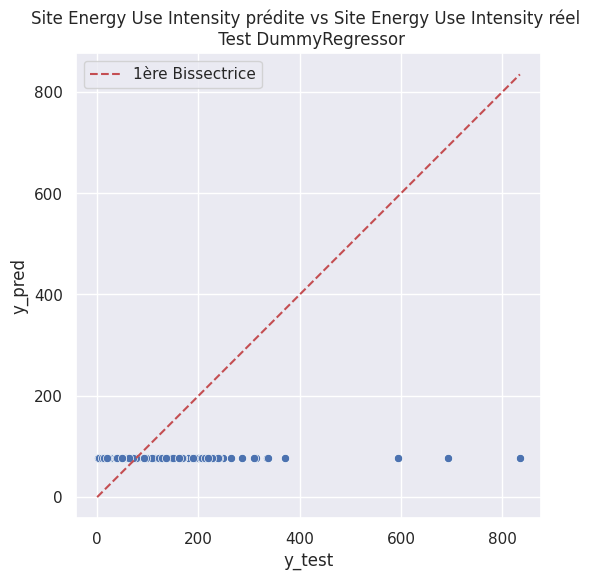

In [19]:
def plot_test(ytest,y_pred,nom_fichier,model,set_,type = None) :
  tar_name = 'Site Energy Use Intensity'
  y_test = ytest
  y_test = np.array(y_test)
  y_pred.shape
  d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
  d_vis['y_test'] = y_test
  d_vis
  if type == 'tree':
    sns.set()
    fig, ax = plt.subplots(figsize =(6,6), dpi = 100)
    sns.lineplot(data = d_vis,x ='y_test', y = 'y_pred', ls = '--')
    sns.scatterplot(data = d_vis,x ='y_test', y = 'y_pred')
    sns.lineplot(x = [0,y_test.max()],y = [0,y_test.max()],ls = '--', color = 'r',  label = '1ère Bissectrice')
  else:
    sns.set()
    fig, ax = plt.subplots(figsize =(6,8), dpi = 100)
    #sns.lineplot(data = d_vis,x ='y_test', y = 'y_pred')
    sns.scatterplot(data = d_vis,x ='y_test', y = 'y_pred')
    sns.lineplot(x = [0,y_test.max()],y = [0,y_test.max()],ls = '--', color = 'r',  label = '1ère Bissectrice')
  ax.set_title(tar_name+' prédite vs '+tar_name+' réel \n Test '+model)
  plt.axis('square')
  plt.savefig('/content/Fichier_N2/'+nom_fichier+'set'+str(set_), bbox_inches = 'tight', dpi = 150)


  

plot_test(ytest,y_pred,'P4_N2_20_','DummyRegressor',set_)


## <a name="C21"> 2.1 LinearRegression() </a>

In [20]:
score = ['r2','neg_mean_absolute_error', 'neg_root_mean_squared_error']

baseline_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('model_1', linear_model.LinearRegression())])

In [21]:
#score = ['neg_mean_absolute_error']
cv = 15
val_cr = model_selection.cross_validate(estimator = baseline_cv,
                                        X = xtrain,
                                        y = ytrain,
                                        scoring= score, cv=cv)
print(val_cr['test_r2'])
print(val_cr['test_neg_mean_absolute_error'])
print(val_cr['test_neg_root_mean_squared_error'])

[0.47788358 0.43747106 0.49350725 0.69121604 0.75623975 0.52858512
 0.46680228 0.02108559 0.39821646 0.49806161 0.33870861 0.12442835
 0.41693682 0.33300717 0.56295735]
[-34.73589758 -36.22307671 -25.65160236 -30.76666686 -33.00000046
 -39.0815711  -30.67435917 -36.57564107 -35.87820525 -35.51025671
 -30.91666697 -33.96923063 -31.981818   -32.29480509 -26.39350647]
[-56.29670597 -51.69020154 -37.20233446 -48.97655914 -45.36372775
 -62.81823308 -46.38050606 -83.94566316 -62.82011105 -62.69770661
 -45.55376518 -48.653063   -43.97827983 -49.84447627 -38.00214736]


In [22]:
val_cr

{'fit_time': array([0.05439258, 0.10718679, 0.11021018, 0.12708211, 0.07347083,
        0.0725286 , 0.08033681, 0.08070874, 0.06129456, 0.08894277,
        0.07608175, 0.06680369, 0.06326795, 0.06473613, 0.07708645]),
 'score_time': array([0.02007771, 0.04719877, 0.04656005, 0.06092238, 0.01874185,
        0.02008009, 0.0182991 , 0.01999497, 0.02150536, 0.01810122,
        0.01960802, 0.01869678, 0.01913857, 0.0178659 , 0.01797009]),
 'test_r2': array([0.47788358, 0.43747106, 0.49350725, 0.69121604, 0.75623975,
        0.52858512, 0.46680228, 0.02108559, 0.39821646, 0.49806161,
        0.33870861, 0.12442835, 0.41693682, 0.33300717, 0.56295735]),
 'test_neg_mean_absolute_error': array([-34.73589758, -36.22307671, -25.65160236, -30.76666686,
        -33.00000046, -39.0815711 , -30.67435917, -36.57564107,
        -35.87820525, -35.51025671, -30.91666697, -33.96923063,
        -31.981818  , -32.29480509, -26.39350647]),
 'test_neg_root_mean_squared_error': array([-56.29670597, -51.6902015

In [23]:
print('Évaluation du modèle de régression linéaire :\nScore moyen R2 = ', 
      round(np.mean(val_cr['test_r2']), 2), '\nScore moyen neg_MAE = ',
      round(np.mean(val_cr['test_neg_mean_absolute_error']), 2),
      '\nRésultat insuffisant, qui servira de baseline aux autres modèles linéaires. ')

Évaluation du modèle de régression linéaire :
Score moyen R2 =  0.44 
Score moyen neg_MAE =  -32.91 
Résultat insuffisant, qui servira de baseline aux autres modèles linéaires. 


In [24]:
reg = baseline_cv.fit(xtrain, ytrain)

In [25]:
ct = reg.named_steps.preprocessor
ct
ct.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('oneHot', OneHotEncoder(use_cat_names=True),
                                 ['TYPE', 'FONCTION_1', 'QUARTIER']),
                                ('numeric', MinMaxScaler(),
                                 ['LATITUDE', 'LONGITUDE', 'ANNÉE_CONST_REN',
                                  'NBRE_IMMEUBLE', 'NBRE_ÉTAGE',
                                  'SUPERFICIE_TOTALE', 'ENERGYSTARScore',
                                  'PARKING', 'STEAM(kBtu)_part',
                                  'Electricity(kBtu)_part',
                                  'NaturalGas(kBtu)_part'])])

In [26]:
xtrain_trans= ct.fit_transform(xtrain,ytrain)
xtrain_trans

,oneHot__TYPE_NONRESIDENTIAL,oneHot__TYPE_CAMPUS,oneHot__TYPE_SCHOOLS,oneHot__FONCTION_1_RETAIL STORE,oneHot__FONCTION_1_OFFICE,oneHot__FONCTION_1_OTHER,oneHot__FONCTION_1_WAREHOUSE,oneHot__FONCTION_1_HOTEL,oneHot__FONCTION_1_WORSHIP FACILITY,oneHot__FONCTION_1_PUBLIC SERVICES,...,numeric__ANNÉE_CONST_REN,numeric__NBRE_IMMEUBLE,numeric__NBRE_ÉTAGE,numeric__SUPERFICIE_TOTALE,numeric__ENERGYSTARScore,numeric__PARKING,numeric__STEAM(kBtu)_part,numeric__Electricity(kBtu)_part,numeric__NaturalGas(kBtu)_part,remainder__Intercept
757,1,0,0,1,0,0,0,0,0,0,...,0.173913,0.0,0.026316,0.006232,0.353535,0.000000,0.0,0.773857,0.226143,1.0
598,1,0,0,0,1,0,0,0,0,0,...,0.017391,0.0,0.039474,0.004935,0.666667,0.000000,0.0,1.000000,0.000000,1.0
215,1,0,0,1,0,0,0,0,0,0,...,0.121739,0.0,0.052632,0.030718,0.242424,0.000000,0.0,1.000000,0.000000,1.0
135,1,0,0,0,0,1,0,0,0,0,...,0.634783,0.0,0.013158,0.028948,0.939600,0.000000,0.0,0.478450,0.521550,1.0
372,1,0,0,0,0,0,1,0,0,0,...,0.495652,0.0,0.013158,0.017402,0.626263,0.000000,0.0,0.240684,0.759316,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,1,0,0,0,1,0,0,0,0,0,...,0.504348,0.0,0.026316,0.003963,0.949495,0.000000,0.0,1.000000,0.000000,1.0
905,1,0,0,0,1,0,0,0,0,0,...,0.573913,0.0,0.013158,0.004349,0.929293,0.000000,0.0,0.528202,0.471798,1.0
1096,1,0,0,0,0,0,1,0,0,0,...,0.686957,0.0,0.013158,0.009396,0.509482,0.000000,0.0,0.551135,0.448865,1.0
235,1,0,0,0,1,0,0,0,0,0,...,0.852174,0.0,0.144737,0.165340,0.717172,0.618315,0.0,1.000000,0.000000,1.0


In [27]:
xtrain_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1167 entries, 757 to 1061
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   oneHot__TYPE_NONRESIDENTIAL                1167 non-null   int64  
 1   oneHot__TYPE_CAMPUS                        1167 non-null   int64  
 2   oneHot__TYPE_SCHOOLS                       1167 non-null   int64  
 3   oneHot__FONCTION_1_RETAIL STORE            1167 non-null   int64  
 4   oneHot__FONCTION_1_OFFICE                  1167 non-null   int64  
 5   oneHot__FONCTION_1_OTHER                   1167 non-null   int64  
 6   oneHot__FONCTION_1_WAREHOUSE               1167 non-null   int64  
 7   oneHot__FONCTION_1_HOTEL                   1167 non-null   int64  
 8   oneHot__FONCTION_1_WORSHIP FACILITY        1167 non-null   int64  
 9   oneHot__FONCTION_1_PUBLIC SERVICES         1167 non-null   int64  
 10  oneHot__FONCTION_1_REC

In [28]:
xtest_trans= ct.transform(xtest)

In [29]:
xtest_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 1108 to 1248
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   oneHot__TYPE_NONRESIDENTIAL                292 non-null    int64  
 1   oneHot__TYPE_CAMPUS                        292 non-null    int64  
 2   oneHot__TYPE_SCHOOLS                       292 non-null    int64  
 3   oneHot__FONCTION_1_RETAIL STORE            292 non-null    int64  
 4   oneHot__FONCTION_1_OFFICE                  292 non-null    int64  
 5   oneHot__FONCTION_1_OTHER                   292 non-null    int64  
 6   oneHot__FONCTION_1_WAREHOUSE               292 non-null    int64  
 7   oneHot__FONCTION_1_HOTEL                   292 non-null    int64  
 8   oneHot__FONCTION_1_WORSHIP FACILITY        292 non-null    int64  
 9   oneHot__FONCTION_1_PUBLIC SERVICES         292 non-null    int64  
 10  oneHot__FONCTION_1_REC

In [30]:
start_time = time.time()
y_pred = reg.predict(xtest)
end_time = time.time()
predict_time = end_time- start_time

score = metrics.r2_score(ytest, y_pred)
mae = metrics.mean_absolute_error(ytest, y_pred)
rmse = metrics.mean_squared_error(ytest, y_pred, squared = False)

score, mae, rmse, predict_time

(0.5809698769315751, 33.80684918909589, 58.87272905072912, 0.03127169609069824)

Conclusion : Dans le pipeline, la méthode de *scaling* est bien calibrée par rapport au set d'entraînement.

In [31]:
reg.named_steps.model_1.coef_

array([-3.42503886e+15, -3.42503886e+15, -3.42503886e+15, -2.30152880e+15,
       -2.30152880e+15, -2.30152880e+15, -2.30152880e+15, -2.30152880e+15,
       -2.30152880e+15, -2.30152880e+15, -2.30152880e+15, -2.30152880e+15,
       -2.30152880e+15, -2.30152880e+15, -2.30152880e+15, -2.30152880e+15,
       -2.30152880e+15, -2.30152880e+15, -2.30152880e+15, -2.30152880e+15,
       -2.30152880e+15, -2.30152880e+15, -2.30152880e+15,  2.68434161e+14,
        2.68434161e+14,  2.68434161e+14,  2.68434161e+14,  2.68434161e+14,
        2.68434161e+14,  2.68434161e+14,  2.68434161e+14,  2.68434161e+14,
        2.68434161e+14,  2.68434161e+14,  2.68434161e+14,  2.68434161e+14,
        3.22500000e+01,  8.91875000e+01,  1.61562500e+01,  1.22500000e+01,
        2.62187500e+01,  1.42812500e+01, -1.00125000e+02,  1.38750000e+01,
       -3.73888334e+15, -5.72210506e+15, -5.72210506e+15,  0.00000000e+00])

In [32]:
feat_importance = reg.named_steps.model_1.coef_
feat_importance
df_fimp = pd.DataFrame(data = feat_importance, index= xtrain_trans.columns.tolist())
#df_fimp
feat_importance.shape

(48,)

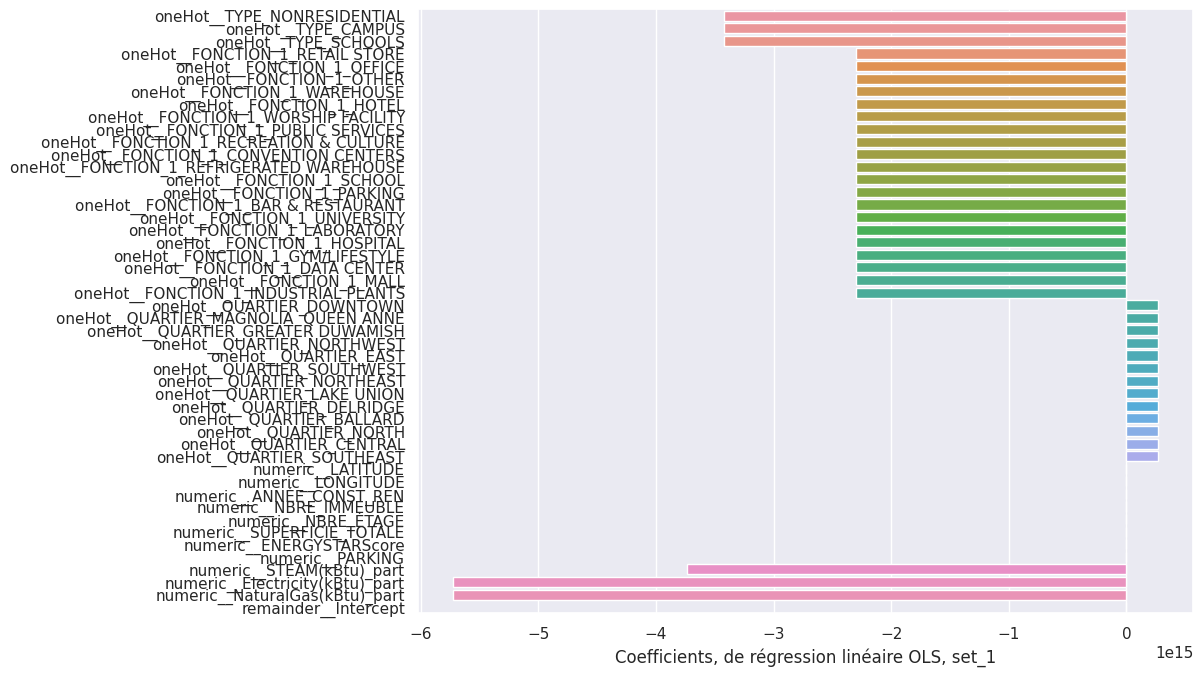

In [33]:
sns.set()
fig,ax = plt.subplots(figsize=(10,8),dpi= 100)
sns.barplot(data = df_fimp.T, orient='h')
ax.set_xlabel('Coefficients, de régression linéaire OLS, set_'+str(set_))
plt.savefig('/content/Fichier_N2/'+'P4_N2_21a_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


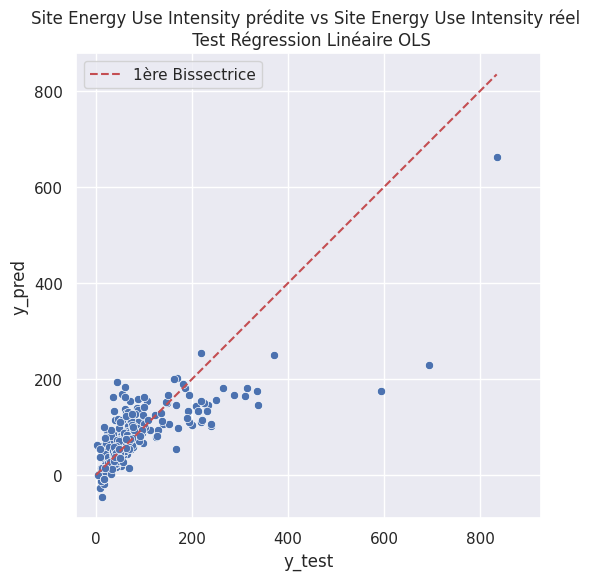

In [34]:
plot_test(ytest,y_pred,'P4_N2_21b_','Régression Linéaire OLS',set_)

In [35]:
df_recap = pd.DataFrame(data = np.nan, columns = ['LinearRegression()'], 
                        index = ['best_param','Temps_training(s)', 'MAE_train_moyen_best_param', 
                                 'R2_train_moyen_best_param', 'RMSE_train_moyen_best_param',
                                'MAE_test_best_param', 'R2_test_best_param', 'RMSE_test_best_param','Temps_prédiction(s)'] )

In [36]:
df_recap.loc['Temps_training(s)'] = round(np.sum(val_cr['fit_time']), 3)
df_recap.loc['MAE_train_moyen_best_param'] = round(np.mean(val_cr['test_neg_mean_absolute_error']), 3)*(-1)
df_recap.loc['R2_train_moyen_best_param'] = round(np.mean(val_cr['test_r2']), 3)
df_recap.loc['RMSE_train_moyen_best_param'] = round(np.mean(val_cr['test_neg_root_mean_squared_error']), 3)*(-1)
df_recap.loc['MAE_test_best_param'] = round(metrics.mean_absolute_error(ytest, y_pred),3)
df_recap.loc['R2_test_best_param'] = round(metrics.r2_score(ytest, y_pred),3)
df_recap.loc['RMSE_test_best_param'] = round(metrics.mean_squared_error(ytest, y_pred, squared = False),3)
df_recap.loc['Temps_prédiction(s)'] = round(predict_time,3)

df_recap

,LinearRegression()
best_param,NaN
Temps_training(s),1.204
MAE_train_moyen_best_param,32.910
R2_train_moyen_best_param,0.436
RMSE_train_moyen_best_param,52.282
MAE_test_best_param,33.807
R2_test_best_param,0.581
RMSE_test_best_param,58.873
Temps_prédiction(s),0.031


## <a href="#C22">2.2 Ridge regression avec GridSearchCV sur $\alpha$ </a>

In [37]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y, 
                                                                 train_size=0.8,
                                                                 random_state = 1)

cv = 15
score = ('neg_mean_absolute_error','r2', 'neg_root_mean_squared_error')
param_grid = {'alpha':[1e-2,0.05, 0.1,1,5,10,12, 100,200]}                                                       
# create pipeline
Ridge_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_ridge', model_selection.GridSearchCV(estimator=linear_model.Ridge(), 
                            param_grid=param_grid,
                            cv=cv,
                            scoring = score,
                            refit='r2',
                            n_jobs = -1))])

In [38]:
Ridge_cv.fit(xtrain, ytrain)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(Ridge_cv.named_steps.grid_search_ridge.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}


In [39]:
#Ridge_cv.named_steps.grid_search_ridge.cv_results_

In [40]:
#Uniquement en utilsiant GridSearchCV
#Retour des meilleurs scores NMAE et R2
#Stockage du dataframe de resultats du modèle


def model_scores(pip,step,model_nom,cv):
    df_results = pd.DataFrame.from_dict(pip.named_steps[step].cv_results_) \
                    .sort_values('rank_test_r2')
    best_r2 = pip.named_steps[step].best_score_
    nmae = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_neg_mean_absolute_error'])*(-1)
    rmse = np.mean(df_results[df_results.rank_test_r2 == 1]['mean_test_neg_root_mean_squared_error'])*(-1)
    best_params = pip.named_steps[step].best_params_
    training_time = round((np.mean(df_results.mean_fit_time)*cv),2)
    print("Meilleur score MAE : {}\nMeilleur Score R2 : {}\nMeilleurs paramètres : {}\nTemps moyen d'entrainement : {}s"\
         .format(round(nmae,3), round(best_r2,3), best_params, training_time))
    start_time = time.time()
    y_pred = pip.predict(xtest)
    end_time = time.time()
    predict_time = end_time- start_time
    print("Temps d'execution de l'agorithme : {:.2} s.".format((predict_time)))


    r2_test = metrics.r2_score(ytest, y_pred)
    mae_test = metrics.mean_absolute_error(ytest, y_pred)
    rmse_test = metrics.mean_squared_error(ytest, y_pred, squared = False)

    df_recap[model_nom] = [best_params, training_time, nmae, best_r2,rmse, mae_test,r2_test,rmse_test, predict_time] 
    return df_results, training_time, nmae, best_r2,mae_test,r2_test, best_params , predict_time


In [41]:
df_res = model_scores(Ridge_cv, 'grid_search_ridge','Ridge()',cv)
#df_res

Meilleur score MAE : 32.659
Meilleur Score R2 : 0.441
Meilleurs paramètres : {'alpha': 0.1}
Temps moyen d'entrainement : 0.16s
Temps d'execution de l'agorithme : 0.064 s.


In [42]:
xtrain.shape

(1167, 15)

In [43]:
df_recap

,LinearRegression(),Ridge()
best_param,NaN,{'alpha': 0.1}
Temps_training(s),1.204,0.16
MAE_train_moyen_best_param,32.910,32.658699
R2_train_moyen_best_param,0.436,0.440675
RMSE_train_moyen_best_param,52.282,52.108407
MAE_test_best_param,33.807,34.162709
R2_test_best_param,0.581,0.578842
RMSE_test_best_param,58.873,59.022035
Temps_prédiction(s),0.031,0.063605


In [44]:
y_pred = Ridge_cv.predict(xtest)
print("\nSur le jeu de test : {:.3f}".format(metrics.r2_score(ytest, y_pred)))


Sur le jeu de test : 0.579


In [45]:
Ridge_cv.named_steps['grid_search_ridge'].best_estimator_.coef_

array([  -7.77574998,    8.63307975,   -0.85732977,   -2.96661667,
        -47.80506241,  -29.28352298,  -91.61911644,  -54.48716626,
       -102.88437427,  -35.05753333,  -11.92187516,  -44.01287692,
        -27.81596115,  -75.50335131,   23.85531139,   39.55718378,
        -59.58633788,   57.32437528,   30.47594994,  -58.52768534,
        562.17537826,  -35.89915027,  -36.01756826,   -4.07555234,
         17.83674766,   -3.83062772,  -16.35208615,   -8.74395774,
         68.80055491,  -22.73729767,    6.75830033,   21.29628867,
         15.24912959,  -25.57441158,  -25.16191075,  -23.46517721,
         28.4404517 ,   88.82097795,   16.49621874,    6.68708835,
         31.72204779,   12.82180814, -100.11973977,   15.00430324,
         19.79490468,  -36.99682223,   24.06262431,    0.        ])

In [46]:
feat_importance = Ridge_cv.named_steps['grid_search_ridge'].best_estimator_.coef_
feat_importance
df_fimp = pd.DataFrame(data = feat_importance, index = xtrain_trans.columns, columns = ['Coefficients'])


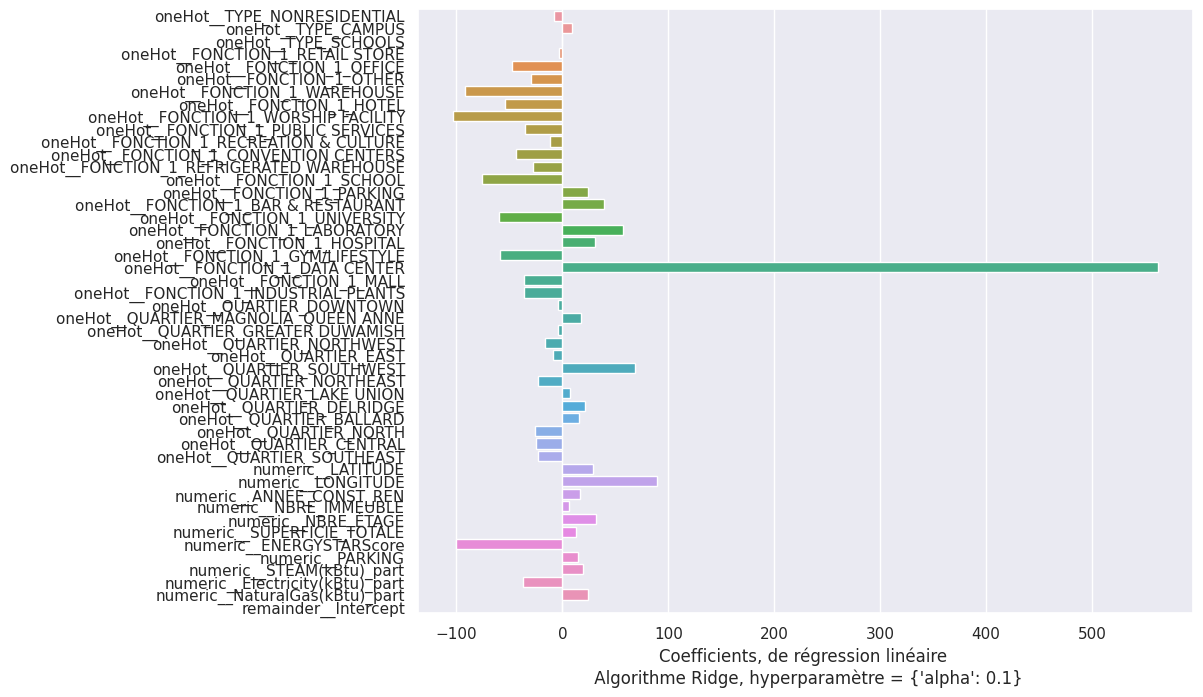

In [47]:
sns.set()
fig,ax = plt.subplots(figsize=(10,8),dpi= 100)
sns.barplot(data = df_fimp.T, orient='h')
ax.set_xlabel('Coefficients, de régression linéaire \n Algorithme Ridge, hyperparamètre = '+str(Ridge_cv.named_steps['grid_search_ridge'].best_params_))
plt.savefig('/content/Fichier_N2/'+'P4_N2_22a_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)

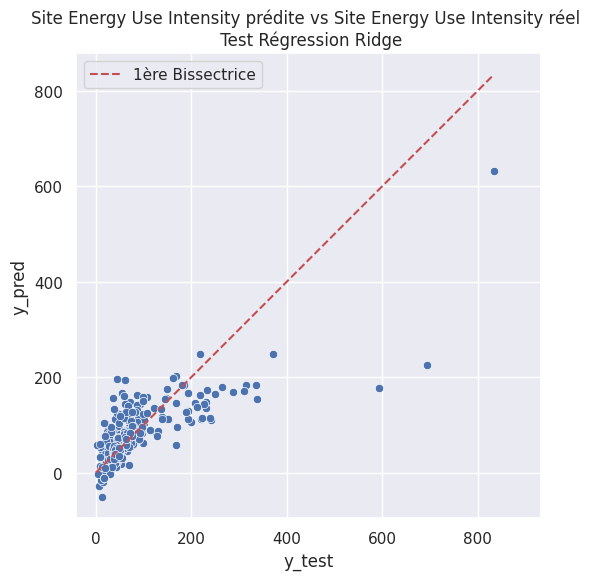

In [48]:
plot_test(ytest,y_pred,'P4_N2_22b_','Régression Ridge',set_)

## <a href="#C23">2.3 Lasso regression avec GridSearchCV sur $\alpha$ </a>

In [49]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y, 
                                                                 train_size=0.8, 
                                                                 random_state = 1)
cv = 15
score = ('neg_mean_absolute_error','r2','neg_root_mean_squared_error')
param_grid = {'alpha':[1e-2,0.05, 0.1,1,5,10,12, 100,200]}                                                       
# create pipeline
Lasso_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_lasso', model_selection.GridSearchCV(estimator=linear_model.Lasso(), 
                            param_grid=param_grid,
                            cv=cv,
                            scoring = score, 
                            refit ='r2',
                            n_jobs = -1))])

In [50]:
Lasso_cv.fit(xtrain, ytrain)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(Lasso_cv.named_steps.grid_search_lasso.best_params_)

df_res = model_scores(Lasso_cv, 'grid_search_lasso','Lasso()',cv)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.1}
Meilleur score MAE : 32.007
Meilleur Score R2 : 0.447
Meilleurs paramètres : {'alpha': 0.1}
Temps moyen d'entrainement : 0.33s
Temps d'execution de l'agorithme : 0.089 s.


In [51]:
df_recap

,LinearRegression(),Ridge(),Lasso()
best_param,NaN,{'alpha': 0.1},{'alpha': 0.1}
Temps_training(s),1.204,0.16,0.33
MAE_train_moyen_best_param,32.910,32.658699,32.007464
R2_train_moyen_best_param,0.436,0.440675,0.447483
RMSE_train_moyen_best_param,52.282,52.108407,52.019458
MAE_test_best_param,33.807,34.162709,33.604954
R2_test_best_param,0.581,0.578842,0.576294
RMSE_test_best_param,58.873,59.022035,59.200276
Temps_prédiction(s),0.031,0.063605,0.088998


In [52]:
Lasso_cv.named_steps['grid_search_lasso'].best_estimator_.coef_

array([ -2.15552695,   7.52449565,   0.        ,  28.65398367,
       -14.09145513,   3.28476237, -58.48967214, -17.62917587,
       -67.13969871,  -0.        ,  20.43701252,  -0.87264582,
         0.        , -36.02798059,  53.08818554,  63.42290671,
       -19.24575659,  80.74914726,  59.99742614,  -6.81180342,
       565.7928814 ,  -0.        ,  -0.        ,  -0.        ,
        12.62931105,  -2.92108696,  -2.6148206 ,   0.        ,
        42.79509122,  -0.        ,  11.34304944,   4.11307889,
         6.60020893,  -0.        ,  -9.90639798,  -5.25687586,
         0.        ,  33.49065111,  17.74451486,   0.        ,
        12.11813968,  15.45180176, -98.05117489,  11.74296946,
         0.        , -57.39244986,   0.        ,   0.        ])

In [53]:
feat_importance = Lasso_cv.named_steps['grid_search_lasso'].best_estimator_.coef_
feat_importance
df_fimp = pd.DataFrame(data = feat_importance, index = xtrain_trans.columns, columns = ['Coefficient'])

In [54]:
df_fimp[df_fimp['Coefficient']== 0.]

,Coefficient
oneHot__TYPE_SCHOOLS,0.0
oneHot__FONCTION_1_PUBLIC SERVICES,-0.0
oneHot__FONCTION_1_REFRIGERATED WAREHOUSE,0.0
oneHot__FONCTION_1_MALL,-0.0
oneHot__FONCTION_1_INDUSTRIAL PLANTS,-0.0
oneHot__QUARTIER_DOWNTOWN,-0.0
oneHot__QUARTIER_EAST,0.0
oneHot__QUARTIER_NORTHEAST,-0.0
oneHot__QUARTIER_NORTH,-0.0
numeric__LATITUDE,0.0


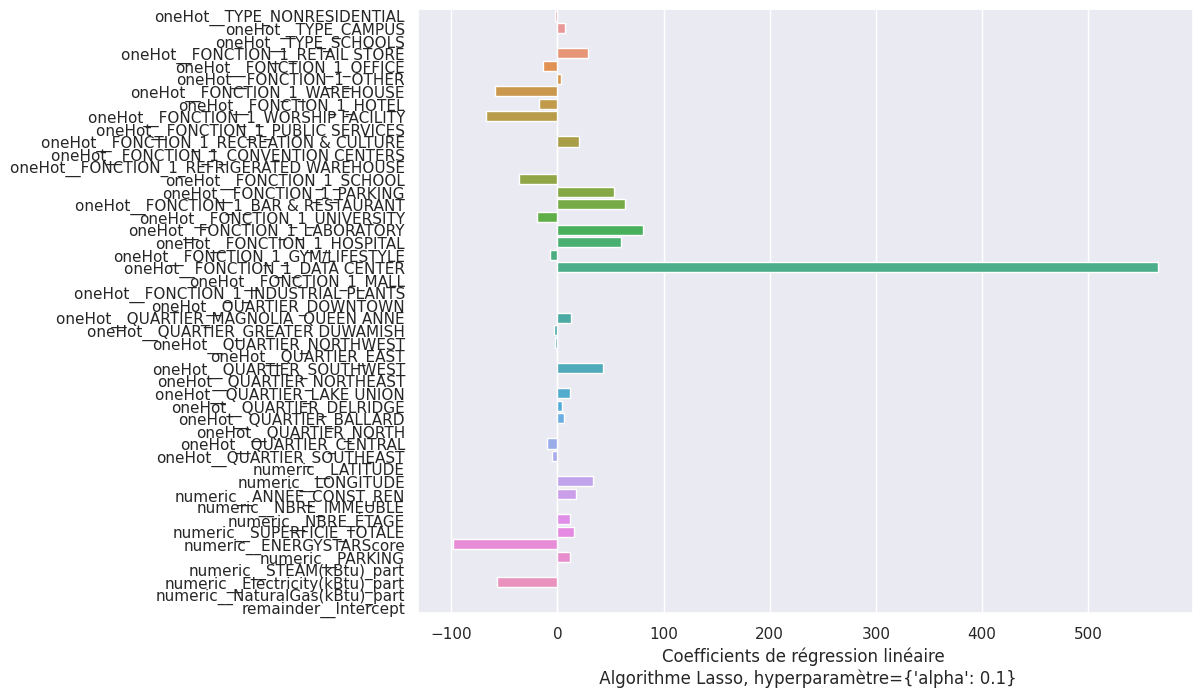

In [55]:
fig,ax = plt.subplots(figsize=(10,8),dpi= 100)
sns.barplot(data = df_fimp.reset_index(), x = 'Coefficient', y = 'index')
ax.set_xlabel('Coefficients de régression linéaire \n Algorithme Lasso, hyperparamètre='+str(Lasso_cv.named_steps['grid_search_lasso'].best_params_))
ax.set_ylabel('')
plt.savefig('/content/Fichier_N2/'+'P4_N2_23a_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)

In [56]:
y_pred = Lasso_cv.predict(xtest)

In [57]:
y_test = ytest
y_test = np.array(y_test)
y_pred.shape
d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
d_vis['y_test'] = y_test


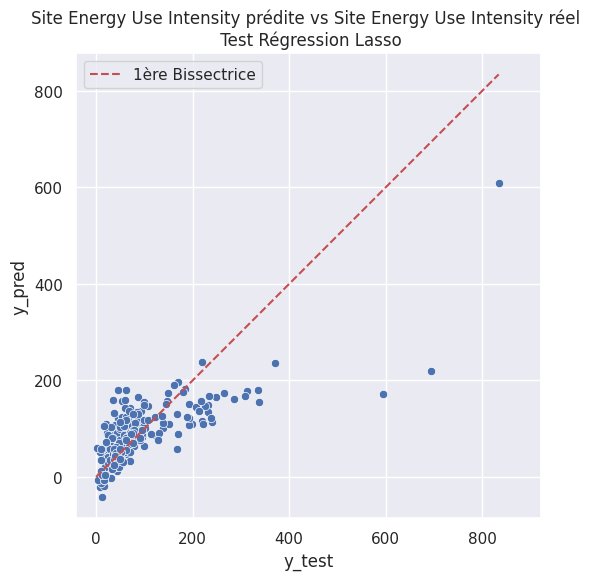

In [58]:
plot_test(ytest,y_pred,'P4_N2_23b_','Régression Lasso',set_)

## <a name="C24"> 2.4 ElasticNET  </a>

In [59]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y,# y_std,
                                                                 train_size=0.8,
                                                                 random_state = 1
                                                             )
cv = 15
score = ('r2','neg_mean_absolute_error','neg_root_mean_squared_error')
param_eNet = {'max_iter': [10, 100, 1000],
              'alpha': np.logspace(-4, 0, num=5),
              'l1_ratio': np.arange(0.0, 1.1, 0.1)}

eNet_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_enet', model_selection.GridSearchCV(estimator=linear_model.ElasticNet(),
                            param_grid=param_eNet,
                            cv=cv,
                            scoring= score,
                            refit='r2',
                            n_jobs = -1))])

In [60]:
eNet_grid_cv.fit(xtrain, ytrain)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHot',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['TYPE', 'FONCTION_1',
                                                   'QUARTIER']),
                                                 ('numeric', MinMaxScaler(),
                                                  ['LATITUDE', 'LONGITUDE',
                                                   'ANNÉE_CONST_REN',
                                                   'NBRE_IMMEUBLE',
                                                   'NBRE_ÉTAGE',
                                                   'SUPERFICIE_TOTALE',
                                                   'ENERGYSTARScore', 'PARKING',
                                                   'STEAM(kBtu)_part',
                                                   'Electricity(kBtu)_part',
                                                   'NaturalGas(kBtu)_part'])])),
                ('grid_search_enet',
                 GridSearchCV(cv=15, estimator=ElasticNet(), n_jobs=-1,
                              param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                                          'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                          'max_iter': [10, 100, 1000]},
                              refit='r2',
                              scoring=('r2', 'neg_mean_absolute_error',
                                       'neg_root_mean_squared_error')))])

In [61]:
df_res = model_scores(eNet_grid_cv,'grid_search_enet','ENET()', cv)

Meilleur score MAE : 31.938
Meilleur Score R2 : 0.448
Meilleurs paramètres : {'alpha': 0.1, 'l1_ratio': 1.0, 'max_iter': 10}
Temps moyen d'entrainement : 0.44s
Temps d'execution de l'agorithme : 0.03 s.


In [62]:
df_recap

,LinearRegression(),Ridge(),Lasso(),ENET()
best_param,NaN,{'alpha': 0.1},{'alpha': 0.1},"{'alpha': 0.1, 'l1_ratio': 1.0, 'max_iter': 10}"
Temps_training(s),1.204,0.16,0.33,0.44
MAE_train_moyen_best_param,32.910,32.658699,32.007464,31.938471
R2_train_moyen_best_param,0.436,0.440675,0.447483,0.447828
RMSE_train_moyen_best_param,52.282,52.108407,52.019458,52.011082
MAE_test_best_param,33.807,34.162709,33.604954,33.694095
R2_test_best_param,0.581,0.578842,0.576294,0.575729
RMSE_test_best_param,58.873,59.022035,59.200276,59.23977
Temps_prédiction(s),0.031,0.063605,0.088998,0.029981


In [63]:
y_pred = eNet_grid_cv.predict(xtest)

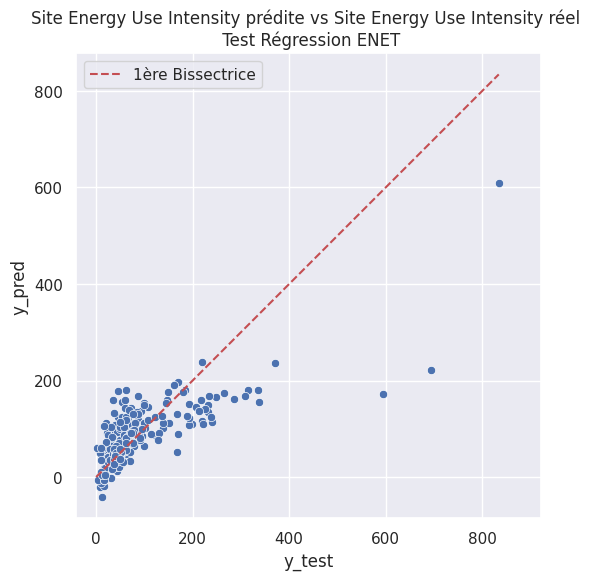

In [64]:
plot_test(ytest,y_pred,'P4_N2_24b_','Régression ENET',set_)

# <a name="C3"> 3. Régression non linéaires  </a>


## <a name="C31"> 3.1 LinearSVR / SVR </a>

In [65]:
from sklearn import svm


In [66]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y,
                                                                 train_size=0.8,
                                                                 random_state = 1
                                                             )

In [67]:
# choisir 6 valeurs pour C, entre 1e-2 et 1e3
C_range = np.logspace(-2, 3, 6)

# choisir 4 valeurs pour gamma, entre 1e-2 et 10
gamma_range = np.logspace(-2, 1, 4)

# grille de paramètres
param_grid = {'C': C_range}
              #'gamma': gamma_range}

# critère de sélection du meilleur modèle
score = ('r2','neg_mean_absolute_error', 'neg_root_mean_squared_error')

cv = 15
SVR = Pipeline(steps=[('preprocessor', preprocessor),
                      ('grid_svr',model_selection.GridSearchCV(estimator = svm.LinearSVR(), 
                                                               param_grid =param_grid, 
                                                               cv=cv, 
                                                               scoring=score,
                                                               refit = 'r2',
                                                               n_jobs = -1))])
                      
                      
                    

In [68]:
# faire tourner la recherche sur grille
SVR.fit(xtrain, ytrain)

df_res = model_scores(SVR,'grid_svr','linearSVR()',cv)

Meilleur score MAE : 30.025
Meilleur Score R2 : 0.394
Meilleurs paramètres : {'C': 1000.0}
Temps moyen d'entrainement : 0.54s
Temps d'execution de l'agorithme : 0.02 s.


In [69]:
df_recap

,LinearRegression(),Ridge(),Lasso(),ENET(),linearSVR()
best_param,NaN,{'alpha': 0.1},{'alpha': 0.1},"{'alpha': 0.1, 'l1_ratio': 1.0, 'max_iter': 10}",{'C': 1000.0}
Temps_training(s),1.204,0.16,0.33,0.44,0.54
MAE_train_moyen_best_param,32.910,32.658699,32.007464,31.938471,30.024659
R2_train_moyen_best_param,0.436,0.440675,0.447483,0.447828,0.393868
RMSE_train_moyen_best_param,52.282,52.108407,52.019458,52.011082,54.653405
MAE_test_best_param,33.807,34.162709,33.604954,33.694095,31.130018
R2_test_best_param,0.581,0.578842,0.576294,0.575729,0.553978
RMSE_test_best_param,58.873,59.022035,59.200276,59.23977,60.739292
Temps_prédiction(s),0.031,0.063605,0.088998,0.029981,0.020113


In [70]:
y_pred = SVR.predict(xtest)

In [71]:
y_test = ytest
y_test = np.array(y_test)
y_pred.shape
d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
d_vis['y_test'] = y_test

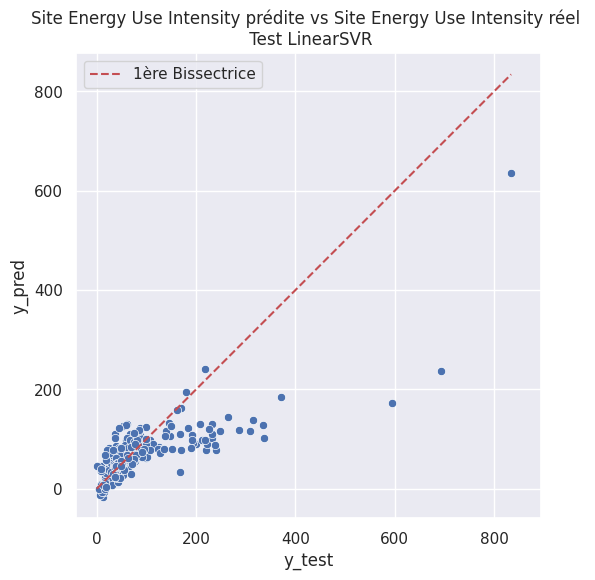

In [72]:
plot_test(ytest,y_pred,'P4_N2_31b_','LinearSVR',set_)

## <a name="C32"> 3.2 DecisionTreeRegressor </a>

In [73]:
from sklearn.tree import DecisionTreeRegressor

In [74]:
X = df.drop(columns =['INT_CONSOMMATION_ENERG_SITE','Intercept' ])
y = df['INT_CONSOMMATION_ENERG_SITE']

In [75]:
xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y,
                                                                train_size=0.8,
                                                               random_state = 1
                                                            )

if (set_ == 1) | (set_ ==3):
  #set1 et set3
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer, cat_features)], remainder='passthrough')
elif set_== 2:
  #set2 
  preprocessor = ColumnTransformer(transformers=[
    ('oneHot', target_transformer0, cat_features),
    ('target', target_transformer1, cat_features_fonction)], remainder='passthrough')

In [76]:
score = ('r2','neg_mean_absolute_error', 'neg_root_mean_squared_error')

param_Tree = {'criterion': ['squared_error', 'absolute_error'],
              'max_depth': [2,3, 4,5, 6],
             }
cv = 15
Tree = Pipeline(steps=[('preprocessor', preprocessor),
                      ('grid_tree',
                       model_selection.GridSearchCV(estimator = DecisionTreeRegressor(random_state=1), 
                                                               param_grid =param_Tree, 
                                                               cv=cv, 
                                                               scoring=score,
                                                               refit = 'r2',
                                                               n_jobs = -1))])



In [77]:
Tree

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHot',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['TYPE', 'FONCTION_1',
                                                   'QUARTIER'])])),
                ('grid_tree',
                 GridSearchCV(cv=15,
                              estimator=DecisionTreeRegressor(random_state=1),
                              n_jobs=-1,
                              param_grid={'criterion': ['squared_error',
                                                        'absolute_error'],
                                          'max_depth': [2, 3, 4, 5, 6]},
                              refit='r2',
                              scoring=('r2', 'neg_mean_absolute_error',
                                       'neg_root_mean_squared_error')))])

In [78]:
Tree.fit(xtrain,ytrain)

df_res = model_scores(Tree,'grid_tree','DecisionTree()',cv)

Meilleur score MAE : 38.063
Meilleur Score R2 : 0.271
Meilleurs paramètres : {'criterion': 'squared_error', 'max_depth': 3}
Temps moyen d'entrainement : 1.4s
Temps d'execution de l'agorithme : 0.012 s.


In [79]:
y_pred = Tree.predict(xtest)

In [80]:
r2_test = metrics.r2_score(ytest, y_pred)
mae_test = metrics.mean_absolute_error(ytest, y_pred)
r2_test, mae_test

(0.4398204877664619, 40.388867202859196)

In [81]:
y_test = ytest
y_test = np.array(y_test)
y_pred.shape
d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
d_vis['y_test'] = y_test

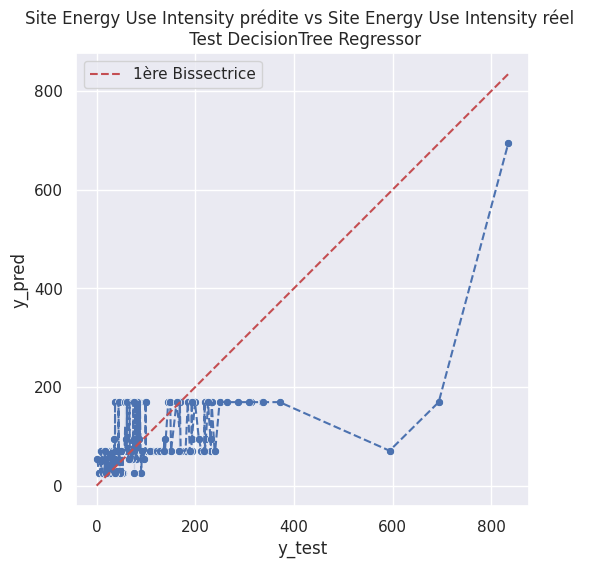

In [82]:
plot_test(ytest,y_pred,'P4_N2_41b_','DecisionTree Regressor',set_, type = 'tree')

In [83]:
ct = Tree.named_steps['preprocessor']
ct.set_output(transform="pandas")
xtest_trans_tree = ct.transform(xtest)



### <a name="C321"> 3.2.bonus Feature Importance <a>

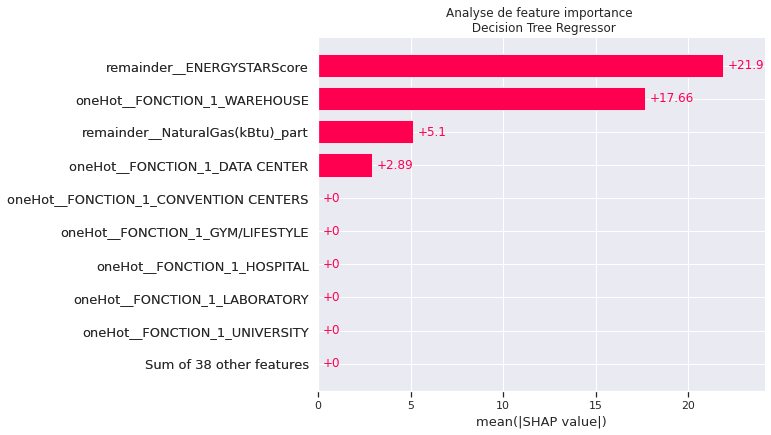

In [84]:
def feat_shap(xtest,model,nomfichier,nommodel,set_):
  # DF, based on which importance is checked
  X_importance = xtest

  # Explain model predictions using shap library:
  explainer = shap.TreeExplainer(model)
  shap_values = explainer(X_importance)

  # Plot summary_plot as barplot:
  shap.plots.bar(shap_values, max_display=10, show = False)
  #shap.summary_plot(shap_values, X_importance, plot_type='bar')
  plt.title('Analyse de feature importance \n '+nommodel)
  plt.savefig('/content/Fichier_N2/'+nomfichier+str(set_)+'.png', bbox_inches = 'tight')
  plt.show()

model = Tree.named_steps['grid_tree'].best_estimator_
feat_shap(xtest_trans_tree,model,'P4_N2_32a_set_','Decision Tree Regressor',set_)

In [85]:
df_recap

,LinearRegression(),Ridge(),Lasso(),ENET(),linearSVR(),DecisionTree()
best_param,NaN,{'alpha': 0.1},{'alpha': 0.1},"{'alpha': 0.1, 'l1_ratio': 1.0, 'max_iter': 10}",{'C': 1000.0},"{'criterion': 'squared_error', 'max_depth': 3}"
Temps_training(s),1.204,0.16,0.33,0.44,0.54,1.4
MAE_train_moyen_best_param,32.910,32.658699,32.007464,31.938471,30.024659,38.063021
R2_train_moyen_best_param,0.436,0.440675,0.447483,0.447828,0.393868,0.270867
RMSE_train_moyen_best_param,52.282,52.108407,52.019458,52.011082,54.653405,60.018717
MAE_test_best_param,33.807,34.162709,33.604954,33.694095,31.130018,40.388867
R2_test_best_param,0.581,0.578842,0.576294,0.575729,0.553978,0.43982
RMSE_test_best_param,58.873,59.022035,59.200276,59.23977,60.739292,68.069907
Temps_prédiction(s),0.031,0.063605,0.088998,0.029981,0.020113,0.012217


## <a name="C33"> 3.3 RandomForestRegressor </a>

In [86]:
from sklearn.ensemble import RandomForestRegressor

param_rfr = {'n_estimators' : [55, 100, 125, 150],
             'max_depth': [25, 26, 27, 28,30],
             #'criterion' :['squared_error', 'absolute_error']
            }
cv = 15
rfr_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_rfr', model_selection.GridSearchCV(RandomForestRegressor(bootstrap = True, 
                                                                           criterion = 'squared_error', 
                                                                           random_state=1),
                            param_grid=param_rfr,
                            cv=cv,
                            scoring=('r2','neg_mean_absolute_error', 'neg_root_mean_squared_error'),
                            refit='r2',
                            return_train_score = True,
                            n_jobs = -1))])

In [87]:
rfr_grid_cv.fit(xtrain, ytrain)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(rfr_grid_cv.named_steps['grid_search_rfr'].best_params_)


df_res = model_scores(rfr_grid_cv,'grid_search_rfr','RandomForest()',cv)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 28, 'n_estimators': 100}
Meilleur score MAE : 29.278
Meilleur Score R2 : 0.502
Meilleurs paramètres : {'max_depth': 28, 'n_estimators': 100}
Temps moyen d'entrainement : 29.71s
Temps d'execution de l'agorithme : 0.033 s.


In [88]:
df_recap

,LinearRegression(),Ridge(),Lasso(),ENET(),linearSVR(),DecisionTree(),RandomForest()
best_param,NaN,{'alpha': 0.1},{'alpha': 0.1},"{'alpha': 0.1, 'l1_ratio': 1.0, 'max_iter': 10}",{'C': 1000.0},"{'criterion': 'squared_error', 'max_depth': 3}","{'max_depth': 28, 'n_estimators': 100}"
Temps_training(s),1.204,0.16,0.33,0.44,0.54,1.4,29.71
MAE_train_moyen_best_param,32.910,32.658699,32.007464,31.938471,30.024659,38.063021,29.277979
R2_train_moyen_best_param,0.436,0.440675,0.447483,0.447828,0.393868,0.270867,0.502043
RMSE_train_moyen_best_param,52.282,52.108407,52.019458,52.011082,54.653405,60.018717,49.185893
MAE_test_best_param,33.807,34.162709,33.604954,33.694095,31.130018,40.388867,29.786549
R2_test_best_param,0.581,0.578842,0.576294,0.575729,0.553978,0.43982,0.6091
RMSE_test_best_param,58.873,59.022035,59.200276,59.23977,60.739292,68.069907,56.862319
Temps_prédiction(s),0.031,0.063605,0.088998,0.029981,0.020113,0.012217,0.033051


In [89]:
y_pred = rfr_grid_cv.predict(xtest)

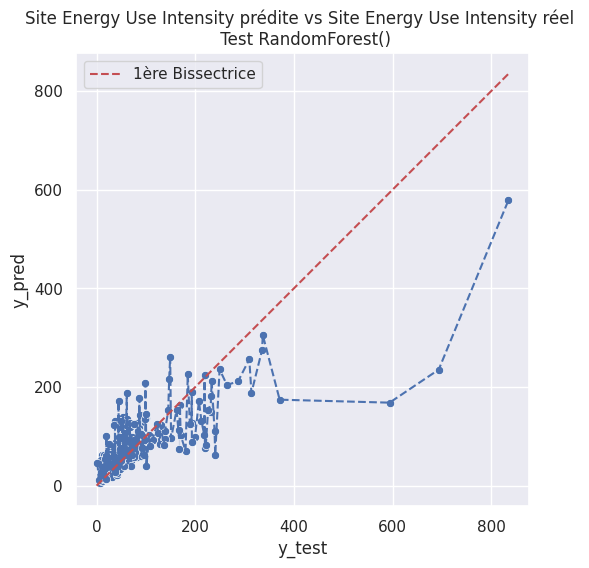

In [90]:
plot_test(ytest,y_pred,'P4_N2_33b_','RandomForest()',set_,type = 'tree')

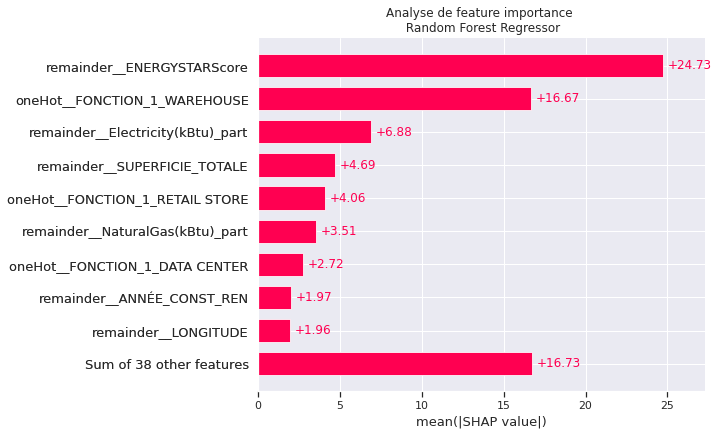

In [91]:
model = rfr_grid_cv.named_steps['grid_search_rfr'].best_estimator_
feat_shap(xtest_trans_tree,model,'P4_N2_33a_','Random Forest Regressor',set_)

## <a name="C34"> 3.4 XGBoost  </a>

In [92]:
import xgboost as xgb

In [93]:

param_xgb = {'max_depth': [ 10, 12, 15, 20],
            'learning_rate': [0.01, 0.1, 0.3],
             'subsample': [0.2, 0.5, 0.8],
             'n_estimators':[35,40,50]

             }
cv = 15
xgb_grid_cv = Pipeline([
    ('preprocessor', preprocessor),
    ('grid_search_xgb', model_selection.GridSearchCV(estimator=xgb.XGBRegressor(random_state = 30), 
                                                     param_grid=param_xgb,
                                                     cv=cv,
                                                     scoring=('r2','neg_mean_absolute_error', 'neg_root_mean_squared_error'),
                                                     return_train_score=True,
                                                     refit='r2',
                                                     n_jobs = -1))])

In [94]:
# Optimiser ce modèle de régression sur le jeu d'entrainement
xgb_grid_cv.fit(xtrain, ytrain)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oneHot',
                                                  OneHotEncoder(use_cat_names=True),
                                                  ['TYPE', 'FONCTION_1',
                                                   'QUARTIER'])])),
                ('grid_search_xgb',
                 GridSearchCV(cv=15,
                              estimator=XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_sto...
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=30, ...),
                              n_jobs=-1,
                              param_grid={'learning_rate': [0.01, 0.1, 0.3],
                                          'max_depth': [10, 12, 15, 20],
                                          'n_estimators': [35, 40, 50],
                                          'subsample': [0.2, 0.5, 0.8]},
                              refit='r2', return_train_score=True,
                              scoring=('r2', 'neg_mean_absolute_error',
                                       'neg_root_mean_squared_error')))])

In [95]:
df_res = model_scores(xgb_grid_cv,'grid_search_xgb','XGBOOST()',cv)

Meilleur score MAE : 26.855
Meilleur Score R2 : 0.576
Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 0.8}
Temps moyen d'entrainement : 10.27s
Temps d'execution de l'agorithme : 0.03 s.


In [96]:
y_pred = xgb_grid_cv.predict(xtest)

In [97]:
y_test = ytest
y_test = np.array(y_test)
y_pred.shape
d_vis = pd.DataFrame(data = y_pred, columns = ['y_pred'])
d_vis['y_test'] = y_test

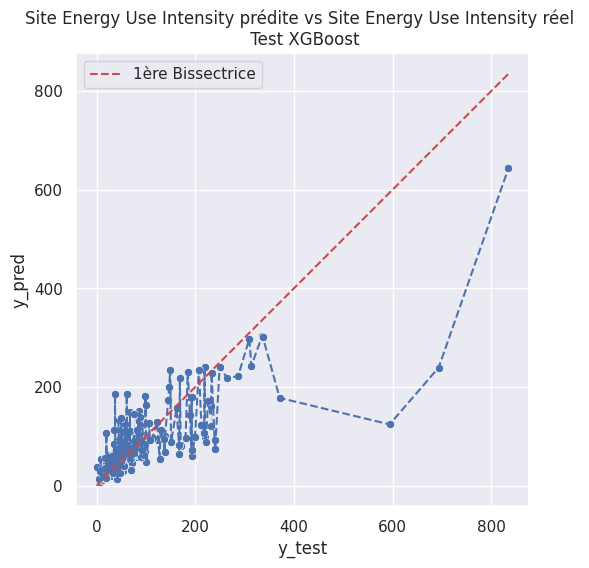

In [98]:
plot_test(ytest,y_pred,'P4_N2_34b_','XGBoost', set_,type = 'tree')

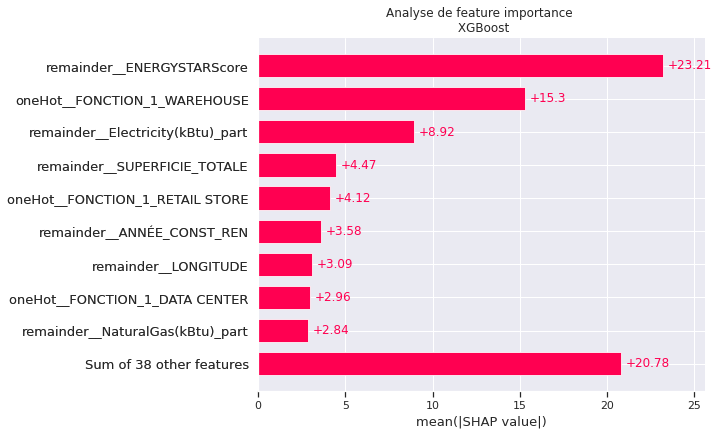

In [99]:
model = xgb_grid_cv.named_steps['grid_search_xgb'].best_estimator_
feat_shap(xtest_trans_tree,model,'P4_N2_34a_','XGBoost',set_)

In [100]:
df_recap

,LinearRegression(),Ridge(),Lasso(),ENET(),linearSVR(),DecisionTree(),RandomForest(),XGBOOST()
best_param,NaN,{'alpha': 0.1},{'alpha': 0.1},"{'alpha': 0.1, 'l1_ratio': 1.0, 'max_iter': 10}",{'C': 1000.0},"{'criterion': 'squared_error', 'max_depth': 3}","{'max_depth': 28, 'n_estimators': 100}","{'learning_rate': 0.1, 'max_depth': 10, 'n_est..."
Temps_training(s),1.204,0.16,0.33,0.44,0.54,1.4,29.71,10.27
MAE_train_moyen_best_param,32.910,32.658699,32.007464,31.938471,30.024659,38.063021,29.277979,26.855171
R2_train_moyen_best_param,0.436,0.440675,0.447483,0.447828,0.393868,0.270867,0.502043,0.575514
RMSE_train_moyen_best_param,52.282,52.108407,52.019458,52.011082,54.653405,60.018717,49.185893,45.39458
MAE_test_best_param,33.807,34.162709,33.604954,33.694095,31.130018,40.388867,29.786549,29.229204
R2_test_best_param,0.581,0.578842,0.576294,0.575729,0.553978,0.43982,0.6091,0.609968
RMSE_test_best_param,58.873,59.022035,59.200276,59.23977,60.739292,68.069907,56.862319,56.799127
Temps_prédiction(s),0.031,0.063605,0.088998,0.029981,0.020113,0.012217,0.033051,0.029554


# <a name="C4"> 4. Conclusion </a>

Pour la prédiction de l'intensité de consommation énergétique, l'algorithme XGBOOST est le plus performant (résultat pour le Set 1)  


In [101]:
df_recap = df_recap.T.reset_index()

In [102]:
df_recap = df_recap.rename(columns = {'index':'Modèle'})
df_recap

,Modèle,best_param,Temps_training(s),MAE_train_moyen_best_param,R2_train_moyen_best_param,RMSE_train_moyen_best_param,MAE_test_best_param,R2_test_best_param,RMSE_test_best_param,Temps_prédiction(s)
0,LinearRegression(),NaN,1.204,32.91,0.436,52.282,33.807,0.581,58.873,0.031
1,Ridge(),{'alpha': 0.1},0.16,32.658699,0.440675,52.108407,34.162709,0.578842,59.022035,0.063605
2,Lasso(),{'alpha': 0.1},0.33,32.007464,0.447483,52.019458,33.604954,0.576294,59.200276,0.088998
3,ENET(),"{'alpha': 0.1, 'l1_ratio': 1.0, 'max_iter': 10}",0.44,31.938471,0.447828,52.011082,33.694095,0.575729,59.23977,0.029981
4,linearSVR(),{'C': 1000.0},0.54,30.024659,0.393868,54.653405,31.130018,0.553978,60.739292,0.020113
5,DecisionTree(),"{'criterion': 'squared_error', 'max_depth': 3}",1.4,38.063021,0.270867,60.018717,40.388867,0.43982,68.069907,0.012217
6,RandomForest(),"{'max_depth': 28, 'n_estimators': 100}",29.71,29.277979,0.502043,49.185893,29.786549,0.6091,56.862319,0.033051
7,XGBOOST(),"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",10.27,26.855171,0.575514,45.39458,29.229204,0.609968,56.799127,0.029554


In [103]:
from google.colab import files
df_recap.to_csv('Fichier_N2/'+'set'+str(set_)+'_res_EUI.csv') 

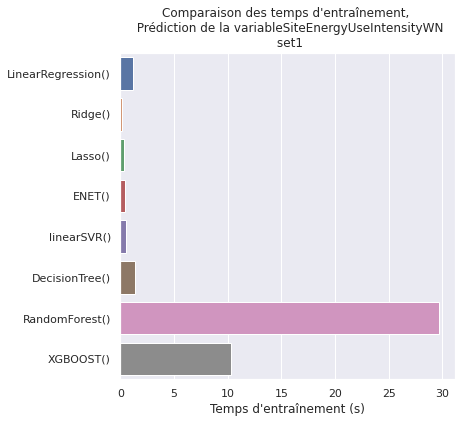

In [104]:
sns.set()
fig, ax = plt.subplots(figsize =(6,6))
sns.barplot(data = df_recap, y = 'Modèle', x = 'Temps_training(s)', orient = 'h')
ax.set_xlabel('Temps d\'entraînement (s)')
ax.set_ylabel('')
ax.set_title('Comparaison des temps d\'entraînement, \n Prédiction de la variable'+tar_name+'\n set'+str(set_))
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.savefig('/content/Fichier_N2/'+'P4_N2_41_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)

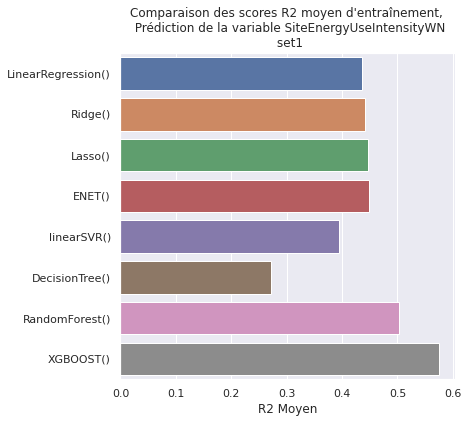

In [105]:
sns.set()
fig, ax = plt.subplots(figsize =(6,6))
sns.barplot(data = df_recap, y = 'Modèle', x = 'R2_train_moyen_best_param', orient = 'h')
ax.set_xlabel('R2 Moyen')
ax.set_ylabel('')
ax.set_title('Comparaison des scores R2 moyen d\'entraînement, \n Prédiction de la variable '+ tar_name+'\n set'+str(set_))
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.savefig('/content/Fichier_N2/'+'P4_N2_42_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


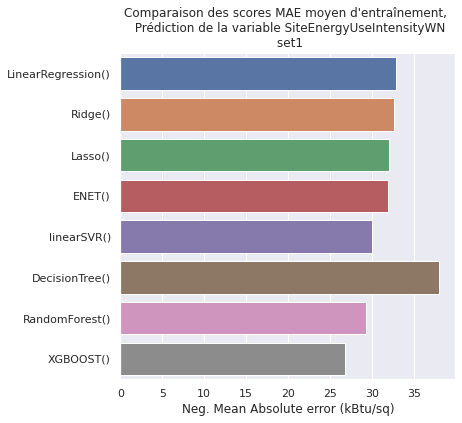

In [106]:
sns.set()
fig, ax = plt.subplots(figsize =(6,6))
sns.barplot(data = df_recap, y = 'Modèle', x = 'MAE_train_moyen_best_param', orient = 'h')
ax.set_xlabel('Neg. Mean Absolute error (kBtu/sq)')
ax.set_ylabel('')
ax.set_title('Comparaison des scores MAE moyen d\'entraînement, \n Prédiction de la variable '+ tar_name+'\n set'+str(set_))
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.savefig('/content/Fichier_N2/'+'P4_N2_43_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


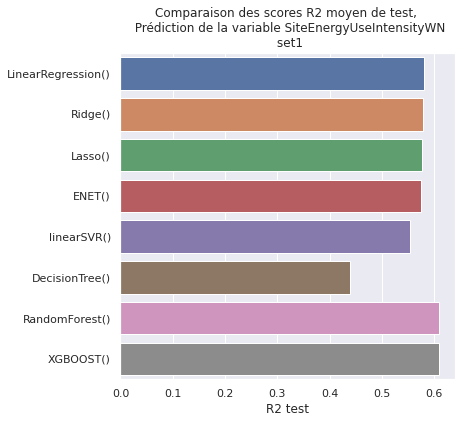

In [107]:
sns.set()
fig, ax = plt.subplots(figsize =(6,6))
sns.barplot(data = df_recap, y = 'Modèle', x = 'R2_test_best_param', orient = 'h')
ax.set_xlabel('R2 test')
ax.set_ylabel('')
ax.set_title('Comparaison des scores R2 moyen de test, \n Prédiction de la variable '+tar_name+'\n set'+str(set_))
#plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
plt.savefig('/content/Fichier_N2/'+'P4_N2_44_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


In [108]:
y_pred_best = xgb_grid_cv.predict(xtest)

In [109]:
#Uniquement pour le set 3 
if set_ == 3:
  file = ['df_set0.csv','df_set3.csv']

  #Choix du fichier 0 ou 1
  df= pd.read_csv(file[0],  
                dtype={'ID' : 'object',      
                      })
  df = df.drop(columns = ['Unnamed: 0','INTENSITÉ_ÉMISSIONS','CONSOMMATION_ENERG_SITE', 'STEAM(kBtu)',
                        'SUPERFICIE_PARKING','Electricity(kBtu)', 'NaturalGas(kBtu)', 'ÉMISSIONS_TOTALES', 
                        'NAN_ENERGY',  
                        'FONCTION_2' ,  'FONCTION_3',
                        'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA',
                        'ThirdLargestPropertyUseTypeGFA'
                      ])
  X = df.drop('INT_CONSOMMATION_ENERG_SITE', axis = 1)
  y = df['INT_CONSOMMATION_ENERG_SITE']

  xtrain, xtest, ytrain, ytest =  model_selection.train_test_split(X, y,
                                                                 train_size=0.8, 
                                                                 random_state = 1,
                                                            )
  

In [110]:
df_test_pred = pd.concat([xtest,ytest],axis=1)
df_test_pred 

,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part,INT_CONSOMMATION_ENERG_SITE
1108,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.58168,-122.33369,1925,1.0,2,25821,63.009904,0.000000,0.0,1.000000,0.000000,8.300000
111,NONRESIDENTIAL,RECREATION & CULTURE,LAKE UNION,47.62759,-122.33661,1900,1.0,1,50000,1.000000,0.000000,0.0,0.503116,0.496884,184.699997
1273,NONRESIDENTIAL,WORSHIP FACILITY,NORTHWEST,47.67783,-122.32577,1978,1.0,2,27500,60.000000,0.000000,0.0,0.595487,0.404513,23.799999
1147,NONRESIDENTIAL,WAREHOUSE,NORTHWEST,47.70281,-122.35623,1990,1.0,2,71874,63.920224,43.672260,0.0,0.366887,0.633113,19.400000
368,NONRESIDENTIAL,OTHER,GREATER DUWAMISH,47.55741,-122.33163,1973,1.0,1,110689,92.384038,0.000000,0.0,0.152289,0.847711,25.200001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NONRESIDENTIAL,OFFICE,LAKE UNION,47.62131,-122.33814,2006,1.0,6,303103,97.000000,36.259951,0.0,0.950527,0.049473,40.900002
1400,NONRESIDENTIAL,HOSPITAL,NORTHWEST,47.71286,-122.33635,2012,1.0,2,53575,40.869034,0.000000,0.0,0.728644,0.271356,593.599976
131,NONRESIDENTIAL,WORSHIP FACILITY,NORTHEAST,47.66182,-122.31113,1952,1.0,2,56772,46.000000,0.000000,0.0,0.399721,0.600279,48.700001
1142,NONRESIDENTIAL,OFFICE,GREATER DUWAMISH,47.57595,-122.33624,1937,1.0,2,39036,93.001962,0.000000,0.0,0.594481,0.405519,39.599998


In [111]:
df_test_pred['y_pred'] = y_pred_best
df_test_pred

,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part,INT_CONSOMMATION_ENERG_SITE,y_pred
1108,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.58168,-122.33369,1925,1.0,2,25821,63.009904,0.000000,0.0,1.000000,0.000000,8.300000,18.211622
111,NONRESIDENTIAL,RECREATION & CULTURE,LAKE UNION,47.62759,-122.33661,1900,1.0,1,50000,1.000000,0.000000,0.0,0.503116,0.496884,184.699997,229.351761
1273,NONRESIDENTIAL,WORSHIP FACILITY,NORTHWEST,47.67783,-122.32577,1978,1.0,2,27500,60.000000,0.000000,0.0,0.595487,0.404513,23.799999,31.882458
1147,NONRESIDENTIAL,WAREHOUSE,NORTHWEST,47.70281,-122.35623,1990,1.0,2,71874,63.920224,43.672260,0.0,0.366887,0.633113,19.400000,57.342960
368,NONRESIDENTIAL,OTHER,GREATER DUWAMISH,47.55741,-122.33163,1973,1.0,1,110689,92.384038,0.000000,0.0,0.152289,0.847711,25.200001,61.369873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NONRESIDENTIAL,OFFICE,LAKE UNION,47.62131,-122.33814,2006,1.0,6,303103,97.000000,36.259951,0.0,0.950527,0.049473,40.900002,46.408161
1400,NONRESIDENTIAL,HOSPITAL,NORTHWEST,47.71286,-122.33635,2012,1.0,2,53575,40.869034,0.000000,0.0,0.728644,0.271356,593.599976,124.105011
131,NONRESIDENTIAL,WORSHIP FACILITY,NORTHEAST,47.66182,-122.31113,1952,1.0,2,56772,46.000000,0.000000,0.0,0.399721,0.600279,48.700001,50.439358
1142,NONRESIDENTIAL,OFFICE,GREATER DUWAMISH,47.57595,-122.33624,1937,1.0,2,39036,93.001962,0.000000,0.0,0.594481,0.405519,39.599998,41.652164


In [112]:
df_test_pred['abs_error'] = np.abs(df_test_pred['INT_CONSOMMATION_ENERG_SITE']- df_test_pred['y_pred'])
df_test_pred

,TYPE,FONCTION_1,QUARTIER,LATITUDE,LONGITUDE,ANNÉE_CONST_REN,NBRE_IMMEUBLE,NBRE_ÉTAGE,SUPERFICIE_TOTALE,ENERGYSTARScore,PARKING,STEAM(kBtu)_part,Electricity(kBtu)_part,NaturalGas(kBtu)_part,INT_CONSOMMATION_ENERG_SITE,y_pred,abs_error
1108,NONRESIDENTIAL,WAREHOUSE,GREATER DUWAMISH,47.58168,-122.33369,1925,1.0,2,25821,63.009904,0.000000,0.0,1.000000,0.000000,8.300000,18.211622,9.911622
111,NONRESIDENTIAL,RECREATION & CULTURE,LAKE UNION,47.62759,-122.33661,1900,1.0,1,50000,1.000000,0.000000,0.0,0.503116,0.496884,184.699997,229.351761,44.651764
1273,NONRESIDENTIAL,WORSHIP FACILITY,NORTHWEST,47.67783,-122.32577,1978,1.0,2,27500,60.000000,0.000000,0.0,0.595487,0.404513,23.799999,31.882458,8.082458
1147,NONRESIDENTIAL,WAREHOUSE,NORTHWEST,47.70281,-122.35623,1990,1.0,2,71874,63.920224,43.672260,0.0,0.366887,0.633113,19.400000,57.342960,37.942961
368,NONRESIDENTIAL,OTHER,GREATER DUWAMISH,47.55741,-122.33163,1973,1.0,1,110689,92.384038,0.000000,0.0,0.152289,0.847711,25.200001,61.369873,36.169872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,NONRESIDENTIAL,OFFICE,LAKE UNION,47.62131,-122.33814,2006,1.0,6,303103,97.000000,36.259951,0.0,0.950527,0.049473,40.900002,46.408161,5.508160
1400,NONRESIDENTIAL,HOSPITAL,NORTHWEST,47.71286,-122.33635,2012,1.0,2,53575,40.869034,0.000000,0.0,0.728644,0.271356,593.599976,124.105011,469.494965
131,NONRESIDENTIAL,WORSHIP FACILITY,NORTHEAST,47.66182,-122.31113,1952,1.0,2,56772,46.000000,0.000000,0.0,0.399721,0.600279,48.700001,50.439358,1.739357
1142,NONRESIDENTIAL,OFFICE,GREATER DUWAMISH,47.57595,-122.33624,1937,1.0,2,39036,93.001962,0.000000,0.0,0.594481,0.405519,39.599998,41.652164,2.052166


In [113]:
np.mean(df_test_pred['abs_error']) #vérification OK

29.229203754359755

In [114]:
df_test_pred.groupby(by='FONCTION_1').mean()['abs_error']

FONCTION_1
BAR & RESTAURANT           67.869316
DATA CENTER               191.395386
HOSPITAL                  469.494965
HOTEL                      22.285664
INDUSTRIAL PLANTS          54.570374
LABORATORY                186.180417
MALL                       17.260735
OFFICE                     16.571716
OTHER                      46.171796
PARKING                    41.692276
PUBLIC SERVICES            13.403221
RECREATION & CULTURE       44.615044
REFRIGERATED WAREHOUSE    102.726860
RETAIL STORE               47.516300
SCHOOL                     21.894099
UNIVERSITY                 46.087020
WAREHOUSE                  12.710185
WORSHIP FACILITY           13.830441
Name: abs_error, dtype: float64

In [115]:
ERR = df_test_pred.groupby(by='FONCTION_1').mean()['abs_error']
ERR = ERR.reset_index()
ERR 

,FONCTION_1,abs_error
0,BAR & RESTAURANT,67.869316
1,DATA CENTER,191.395386
2,HOSPITAL,469.494965
3,HOTEL,22.285664
4,INDUSTRIAL PLANTS,54.570374
5,LABORATORY,186.180417
6,MALL,17.260735
7,OFFICE,16.571716
8,OTHER,46.171796
9,PARKING,41.692276


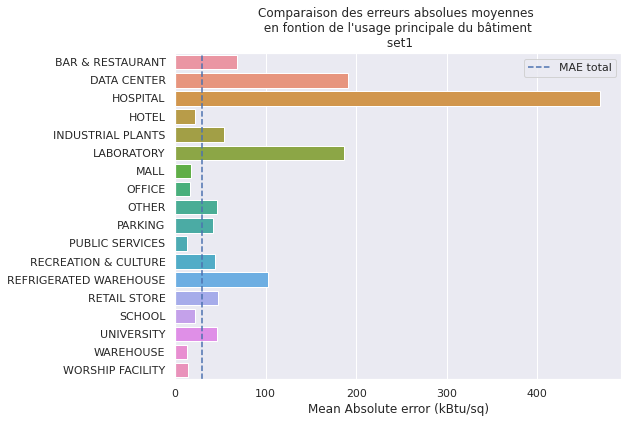

In [116]:
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
g = sns.barplot(data = ERR, y = 'FONCTION_1', x = 'abs_error',
            orient = 'h')
vline = g.axvline(np.mean(df_test_pred['abs_error']), ls = '--', label = 'MAE total')
ax.set_ylabel('')
ax.set_xlabel('Mean Absolute error (kBtu/sq)')
ax.set_title('Comparaison des erreurs absolues moyennes \n en fontion de l\'usage principale du bâtiment \n set'+str(set_))
plt.legend()
plt.savefig('/content/Fichier_N2/'+'P4_N2_45_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


In [117]:
ERR = df_test_pred.groupby(by='QUARTIER').mean()['abs_error']
ERR = ERR.reset_index()
ERR 

,QUARTIER,abs_error
0,BALLARD,37.119761
1,CENTRAL,18.815527
2,DELRIDGE,29.598756
3,DOWNTOWN,27.858569
4,EAST,22.984952
5,GREATER DUWAMISH,16.253353
6,LAKE UNION,35.156933
7,MAGNOLIA QUEEN ANNE,25.165425
8,NORTH,25.932677
9,NORTHEAST,45.820686


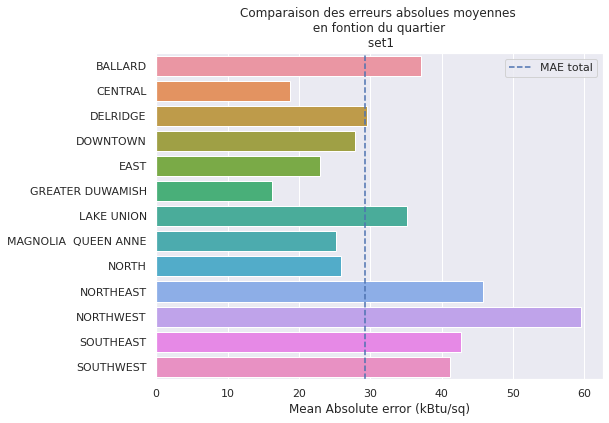

In [118]:
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
g = sns.barplot(data = ERR, y = 'QUARTIER', x = 'abs_error',
            orient = 'h')
vline = g.axvline(np.mean(df_test_pred['abs_error']), ls = '--', label = 'MAE total')

ax.set_ylabel('')
ax.set_xlabel('Mean Absolute error (kBtu/sq)')
ax.set_title('Comparaison des erreurs absolues moyennes \n en fontion du quartier \n set'+str(set_))
plt.legend()
plt.savefig('/content/Fichier_N2/'+'P4_N2_46_set'+str(set_)+'png', bbox_inches = 'tight', dpi = 150)


In [119]:
ERR = df_test_pred.groupby(by='TYPE').mean()['abs_error']
ERR = ERR.reset_index()
ERR 

,TYPE,abs_error
0,CAMPUS,32.626349
1,NONRESIDENTIAL,29.263492
2,SCHOOLS,17.531633


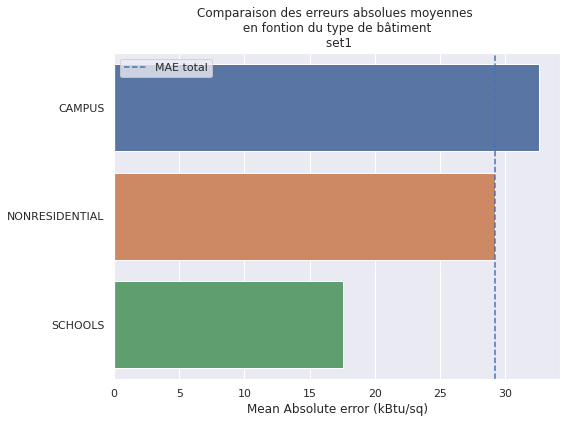

In [120]:
sns.set()
fig, ax = plt.subplots(figsize=(8,6))
g = sns.barplot(data = ERR, y = 'TYPE', x = 'abs_error',
            orient = 'h')
vline = g.axvline(np.mean(df_test_pred['abs_error']), ls = '--', label = 'MAE total')

ax.set_ylabel('')
ax.set_xlabel('Mean Absolute error (kBtu/sq)')
ax.set_title('Comparaison des erreurs absolues moyennes \n en fontion du type de bâtiment \n set'+str(set_))
plt.legend()
plt.savefig('/content/Fichier_N2/'+'P4_N2_47_set'+str(set_)+'.png', bbox_inches = 'tight', dpi = 150)


In [121]:
!zip -r Fichier_N2.zip Fichier_N2

  adding: Fichier_N2/ (stored 0%)
  adding: Fichier_N2/P4_N2_34b_set1.png (deflated 6%)
  adding: Fichier_N2/P4_N2_45_set1.png (deflated 14%)
  adding: Fichier_N2/P4_N2_41b_set1.png (deflated 7%)
  adding: Fichier_N2/P4_N2_32a_set_1.png (deflated 15%)
  adding: Fichier_N2/P4_N2_33b_set1.png (deflated 7%)
  adding: Fichier_N2/P4_N2_47_set1.png (deflated 20%)
  adding: Fichier_N2/P4_N2_33a_1.png (deflated 12%)
  adding: Fichier_N2/P4_N2_44_set1.png (deflated 18%)
  adding: Fichier_N2/P4_N2_20_set1.png (deflated 11%)
  adding: Fichier_N2/P4_N2_22a_set1.png (deflated 18%)
  adding: Fichier_N2/P4_N2_23b_set1.png (deflated 10%)
  adding: Fichier_N2/P4_N2_31b_set1.png (deflated 10%)
  adding: Fichier_N2/P4_N2_41_set1.png (deflated 20%)
  adding: Fichier_N2/P4_N2_23a_set1.png (deflated 19%)
  adding: Fichier_N2/set1_res_EUI.csv (deflated 45%)
  adding: Fichier_N2/P4_N2_46_set1png.png (deflated 16%)
  adding: Fichier_N2/P4_N2_42_set1.png (deflated 18%)
  adding: Fichier_N2/P4_N2_43_set1.png (de

In [122]:
files.download('Fichier_N2.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>